## HW4 Solution

## Q1: the TD($\lambda$) algorithm (5%)
Consider a larger version of the Random Walk problem. 
Now we have 19 states instead of 5 and the left terminal state gives a reward of -1. 
The starting state is still the centre state. 

**Task**:
- Implement the off-line $\lambda$-return / TD($\lambda$) algorithm:
- Compare the RMS(root mean square) error averaged over the 19 states between the predictions at the end of the episode for the 19
states and their true values, over the first 10 episodes, and over 10 runs (10 different sequence of walks). In other words, for each run, you generate 10 episodes and use TD($\lambda$) to learn the value. Then you calculate the difference between the learned value and the true value, square the difference, average it over 10 runs and take the square root. 

- Plot the averaged RMS error vs $\alpha$ values for the following $\lambda$-values:

parameter settings: 
```
lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 0.55, 0.05),
          np.arange(0, 0.22, 0.02),
          np.arange(0, 0.11, 0.01)]
```

## First, let us review the TD($\lambda$) algorithm

![alt txt](./graphs/lambda_1.png)
![alt txt](./graphs/lambda_2.png)

In [1]:
# Iterative policy evaluation
import numpy as np
true_values = np.zeros(21)
for k in np.arange(1000):
    true_values[1] = -0.5 + 0.5 * true_values[2]
    for j in np.arange(1, 19):
        true_values[j] = 0.5 * (true_values[j-1] + true_values[j+1])
    true_values[19] = 0.5 + 0.5 * true_values[18]

print(true_values)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 0.  ]


In [2]:
# Pass the reward trajectory from time step t up to n'th step
import numpy as np
import matplotlib.pyplot as plt
left = 0
right = 1
def random_policy():
    return np.random.binomial(1, 0.5)

class RandomWalkWide:
    def __init__(self, initial_state):
        self.initial_state = initial_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    # write step function that returns obs(next state), reward, is_done
    def step(self, action):
        if self.state == 18 and action == right:
            self.state += 1
            self.is_terminal = True
            self.reward = 1.0
        elif self.state == 1 and action == left:
            self.state -= 1
            self.is_terminal = True
            self.reward = -1.0
        else:
            if action == left:
                self.state -= 1
                self.is_terminal = False
                self.reward = 0.0

            else:
                self.state += 1
                self.is_terminal = False
                self.reward = 0.0

        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state
    
def n_step_reward(r, values, current_t, total_time, state_history, gam):
    n_steps = len(r)
    gamma_power = 1.0
    r_n = 0.0

    for n in range(n_steps):
        r_n += gamma_power * r[n]
        gamma_power *= gam

    end_time = min(current_t + n_steps, total_time)
    state = state_history[end_time]
    r_n += gamma_power * values[state]

    return r_n

def temporal_difference_lambda(values, state_history, r_trajectory, current_t, alpha=0.1, lam=1.0):
    lambda_r = 0.0
    lambda_power = 1.0
    total_time = len(state_history)
    total_n = total_time - current_t

    for n in range(1, max(total_n, 1)):
        lambda_r += lambda_power * n_step_reward(r_trajectory[current_t:current_t+n], values, current_t,
                                                 total_time, state_history, 1.0)
        lambda_power *= lam

    lambda_r = (1.0 - lam) * lambda_r + lambda_power * np.sum(r_trajectory[current_t:total_time])
    current_state = state_history[current_t]
    return values[current_state] + alpha * (lambda_r - values[current_state])


def root_mean_square_error(values, true_values):
    diff = values - true_values
    mse = np.mean(diff ** 2)
    return np.sqrt(mse)


def plot_rms_error_temporal_lambda(errors, alphas, lambdas):
    for i in range(len(lambdas)):
        plt.plot(alphas[i], errors[i, :], label=r'$\lambda$ = ' + str(lambdas[i]))
    plt.ylabel('RMS error averaged over states')
    plt.xlabel(r'$\alpha$')
    plt.title(r'Off-line $\lambda$-return')
    plt.ylim(0.25, 0.65)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.show()


true_values = np.arange(-20, 22, 2) / 20.0
true_values[0] = true_values[20] = 0.0

initial_state = 10
env = RandomWalkWide(initial_state)

episodes = 10
n_runs = 10

lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
alphas = [np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 1.1, 0.1),
          np.arange(0, 0.55, 0.05),
          np.arange(0, 0.22, 0.02),
          np.arange(0, 0.11, 0.01)]

# arrays to store rms for different values of alphas
rms = np.empty((n_runs, len(lambdas), len(alphas[0])))

for n in range(n_runs):
    print("Number of current run:", n + 1)
    for lambda_idx, lam in zip(range(len(lambdas)), lambdas):
        for alpha_idx, alpha in zip(range(len(alphas[lambda_idx])), alphas[lambda_idx]):
            values = np.zeros(21)
            error = 0.0
            for i in range(1, episodes + 1):
                state = env.reset()
                state_history = [state]
                done = False
                reward_trajectory = []
                
                while not done:
                    action = random_policy()
                    next_state, r, done = env.step(action)
                    reward_trajectory.append(r)
                    state_history.append(next_state)

                for t, state in zip(range(len(state_history)), state_history):
                    values[state] = temporal_difference_lambda(values, state_history, reward_trajectory, t,
                                                               alpha=alpha, lam=lam)

                error += root_mean_square_error(values[1:20], true_values[1:20])

            rms[n, lambda_idx, alpha_idx] = error / episodes

rms = np.mean(rms, axis=0)



Number of current run: 1
Number of current run: 2
Number of current run: 3
Number of current run: 4
Number of current run: 5
Number of current run: 6
Number of current run: 7
Number of current run: 8
Number of current run: 9
Number of current run: 10


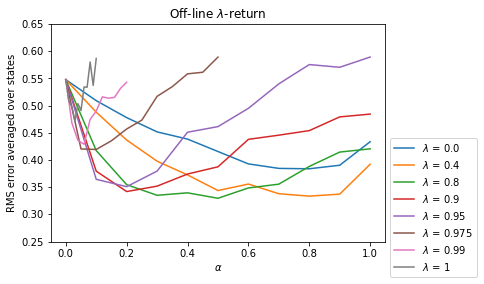

In [3]:
plot_rms_error_temporal_lambda(rms, alphas, lambdas)

## Q2: Implement the double Q-learning algorithm on the Cliff Walking example (5%)

#### Task:
- Set the number of episodes to 1000
- Output the estimated optimal policy
- Plot the average reward during episodes (see the plot in Seminar 4)

## First, let us review the double Q-learning algorithm

<img src="./graphs/double_q_learning.png" width="750" height="450">

## Second, let us implement the Cliff Walking environment

In [4]:
world_width = 12
world_height = 4 

# actions
up = 0
left = 1
right = 2
down = 3
actions = [up, left, right, down]

class CliffWalking:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    def is_cliff(self):
        cliff = np.zeros((world_height, world_width), dtype=bool)
        cliff[3, 1: -1] = True
        return cliff[tuple(self.state)]

    # return next_state, reward, done
    def step(self, action):
        i, j = self.state

        if action == up:
            self.state = [max(i - 1, 0), j]
        elif action == left:
            self.state = [i, max(j - 1, 0)]
        elif action == right:
            self.state = [i, min(j + 1, world_width - 1)]
        elif action == down:
            self.state = [min(i + 1, world_height - 1), j]
        else:
            assert False, "Actions should be in the range of (0, 4)"

        if self.is_cliff():
            self.state = self.initial_state
            self.reward = -100.0
            self.is_terminal = False
        elif self.state == self.goal_state:
            self.state = self.state
            self.reward = 0.0
            self.is_terminal = True
        else:
            self.reward = -1.0
            self.is_terminal = False
        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

## Finally, let us implement the double Q-learning algorithm

In [5]:
start_position = [3, 0]  
goal = [3, 11]

def eps_greedy_policy(qsa, epsilon=0.1):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(qsa) if value_ == np.max(qsa)])


def double_q_learning(q1, q2, state, action, reward, next_state, alpha=0.1, gamma=1.0):
    state_row, state_col = state
    next_state_row, next_state_col = next_state
    update_q1 = np.random.choice([True, False])
    if update_q1:
        a1 = eps_greedy_policy(q1[next_state_row, next_state_col,:], epsilon=0)
        q1[state_row, state_col, action] += alpha * (reward + gamma * q2[next_state_row, next_state_col,a1] - q1[state_row, state_col, action])
    else:
        a2 = eps_greedy_policy(q2[next_state_row, next_state_col,:], epsilon=0)
        q2[state_row, state_col, action] += alpha * (reward + gamma * q1[next_state_row, next_state_col,a2] - q2[state_row, state_col, action])
    return q1,q2

In [6]:
runs = 10
episodes = 1000
rewards_double_qlearning = np.zeros(episodes)
env_double_q_learning = CliffWalking(start_position, goal)

for r in range(runs):
    print("Number of current run:", r + 1)
    q1_double_qlearning = np.zeros((world_height, world_width, len(actions)))
    q2_double_qlearning = np.zeros((world_height, world_width, len(actions)))

    for i in range(episodes):
        state_double_q = env_double_q_learning.reset()
        done_double_q = False
        g_double_q = 0.0
        
        while not done_double_q:
            row_double_q, col_double_q = state_double_q
            a_double_q = eps_greedy_policy(q1_double_qlearning[row_double_q, col_double_q, :] + q2_double_qlearning[row_double_q, col_double_q, :])
            next_state_double_q, r_double_q, done_double_q = env_double_q_learning.step(a_double_q)
            g_double_q += r_double_q

            # Double-Q-learning updates
            q1_double_qlearning, q2_double_qlearning = double_q_learning(q1_double_qlearning, q2_double_qlearning, state_double_q, a_double_q, r_double_q, next_state_double_q)
            state_double_q = next_state_double_q

        rewards_double_qlearning[i] += g_double_q

Number of current run: 1
Number of current run: 2
Number of current run: 3
Number of current run: 4
Number of current run: 5
Number of current run: 6
Number of current run: 7
Number of current run: 8
Number of current run: 9
Number of current run: 10


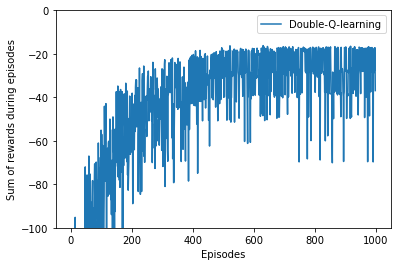

In [7]:
def plot_rewards(plots):
    plt.figure()
    for plot in plots:
        method, method_title = plot
        plt.plot(method, label=method_title)
    # plt.plot(r_qlearning, label='Q-learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episodes')
    plt.ylim([-100, 0])
    plt.legend()
    plt.show()

rewards_double_qlearning /= runs 

plot_rewards([[rewards_double_qlearning, 'Double-Q-learning']])

In [8]:
def print_optimal_policy(policy, method):
    policy_display = np.empty_like(policy, dtype=str)
    for i in range(0, world_height):
        for j in range(0, world_width):
            if [i, j] == [3, 11]:
                policy_display[i, j] = 'G'
                continue
            if i == 3 and j in np.arange(1,11): 
                policy_display[i, j] = 'C'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'
    print(method + ' Optimal policy is:')
    for row in policy_display:
        print(row)
        
optimal_policy = np.argmax(q1_double_qlearning + q2_double_qlearning, axis=2)
print_optimal_policy(optimal_policy, 'Double Q-Learning')

Double Q-Learning Optimal policy is:
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'U' 'R' 'R' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']
